In this assignment, we will implement Domain-Adversarial Training of Neural Networks on SVHN$\rightarrow$MNIST task. The [DANN](https://arxiv.org/pdf/1505.07818.pdf) is a popular unsupervised Domain Adaptation paper which uses the principle of adversarial learning to align the source and target datasets. A classifier trained on the source data can now classify the target data effectively. 

In this assignment we will treat the SVHN dataset of digits as the source domain and the MNIST dataset of digits as the target domain. Note that both the domains need to have the same categories. 

**It will be ideal to solve this assignemnet on a computer with a GPU**. The Coursera platform does not support a GPU. You may want to explore [Google Colab](https://www.youtube.com/watch?v=inN8seMm7UI&ab_channel=TensorFlow) or [Kaggle](https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu)

Along with submitting the Python notebook, save the notebook along with its output after executing all the cells as a .html file and submit the html file as well. 

In [28]:
# Imports
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch import optim
import math
import torch.nn.functional as F
from torch.autograd import Function
from sklearn.metrics import accuracy_score
import numpy as np
import numpy.testing as npt
import random
import os
from matplotlib import pyplot as plt
from digits import get_mnist
from digits import get_svhn

In [29]:
## The following random seeds are just for deterministic behaviour of the code and evaluation

##############################################################################
################### DO NOT MODIFY THE CODE BELOW #############################    
##############################################################################
manual_seed = 0

random.seed(manual_seed)
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manual_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = '0'
    
############################################################################### 

In [30]:
is_cuda = torch.cuda.is_available()
#is_cuda=False
print("GPU available: " + str(is_cuda))

GPU available: True


### Download Source Data

We will not use DataLoaders for this assignment becasue the dataset is small and it is faster to train with the dataset loaded in the memory. 

Src Train Min: Value-  -1.0
Src Train Max: Value-  1.0
Src Test Min: Value-  -1.0
Src Test Max: Value-  1.0
src_trX.shape:  (73257, 3, 32, 32)
src_trY.shape:  (73257,)
src_tsX.shape:  (26032, 3, 32, 32)
src_tsY.shape:  (26032,)
labels
[[1 9 2 3 2 5 9 3 3 1]
 [3 3 2 8 7 4 4 1 2 8]
 [1 6 2 3 6 3 4 2 5 8]
 [1 6 2 3 7 9 5 3 2 2]
 [2 6 2 2 5 1 5 4 7 8]
 [5 2 1 0 6 1 9 1 1 8]
 [3 6 5 1 4 4 1 6 3 4]
 [2 0 1 3 2 5 4 1 4 2]
 [8 3 8 6 0 1 5 1 1 2]
 [9 1 6 9 2 6 1 2 0 6]]


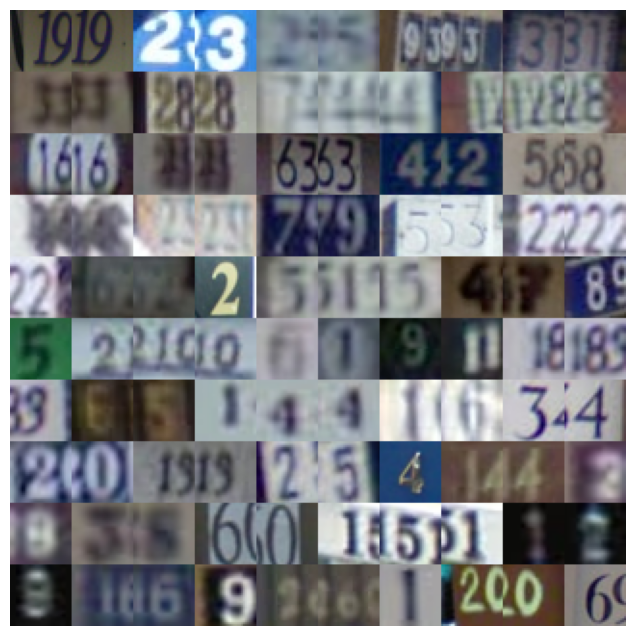

In [31]:
getRGB = True
src_trX, src_trY, src_tsX, src_tsY = get_svhn(getRGB=getRGB)
#m,_,_,_ = src_trX.shape
#tr_idx = np.random.choice(m,min(m,TRAIN_SAMPLES_TO_USE))
#src_trX = src_trX[tr_idx,:,:,:]
#src_trY = src_trY[tr_idx]
#m,_,_,_ = src_tsX.shape
#ts_idx = np.random.choice(m,min(m,TEST_SAMPLES_TO_USE))
#src_tsX = src_tsX[ts_idx,:,:,:]
#src_tsY = src_tsY[ts_idx]
print('Src Train Min: Value- ',np.min(src_trX))
print('Src Train Max: Value- ',np.max(src_trX))
print('Src Test Min: Value- ',np.min(src_tsX))
print('Src Test Max: Value- ',np.max(src_tsX))
print('src_trX.shape: ', src_trX.shape)
print('src_trY.shape: ', src_trY.shape)
print('src_tsX.shape: ', src_tsX.shape)
print('src_tsY.shape: ', src_tsY.shape)

#Let's visualize few samples and their labels from the train and test dataset.
if getRGB:
    # For RGB svhn
    visx_tr = src_trX[:50,:,:,:].reshape(5,10,3,32,32).transpose(0,3,1,4,2).reshape(32*5,-1,3)
    visx_ts = src_tsX[:50,:,:,:].reshape(5,10,3,32,32).transpose(0,3,1,4,2).reshape(32*5,-1,3)
    visx = np.concatenate((visx_tr,visx_ts), axis=0)
    visx = (visx+1)/2. #scaling back to [0-1]
else:
    # For grayscale svhn
    visx_tr = src_trX[:50,:,:,:].squeeze().reshape(5,10,32,32).transpose(0,2,1,3).reshape(32*5,-1)
    visx_ts = src_tsX[:50,:,:,:].squeeze().reshape(5,10,32,32).transpose(0,2,1,3).reshape(32*5,-1)
    visx = np.concatenate((visx_tr,visx_ts), axis=0)

visy = np.concatenate((src_trY[:50],src_tsY[:50])).reshape(10,-1)
print('labels')
print(visy)
plt.figure(figsize = (8,8))
plt.axis('off')
if getRGB:
    plt.imshow(visx)
else:
    plt.imshow(visx,cmap='gray')

#convert to torch tensor
src_trX = torch.tensor(src_trX)
src_trY = torch.tensor(src_trY)
src_tsX = torch.tensor(src_tsX)
src_tsY = torch.tensor(src_tsY)

### Download Target Data

We will not use DataLoaders for this assignment becasue the dataset is small and it is faster to train with the dataset loaded in the memory. 

Tgt Train Min: Value-  -1.0
Tgt Train Max: Value-  1.0
Tgt Test Min: Value-  -1.0
Tgt Test Max: Value-  1.0
tgt_trX.shape:  (60000, 3, 28, 28)
tgt_trY.shape:  (60000,)
tgt_tsX.shape:  (10000, 3, 28, 28)
tgt_tsY.shape:  (10000,)
labels
[[5 0 4 1 9 2 1 3 1 4]
 [3 5 3 6 1 7 2 8 6 9]
 [4 0 9 1 1 2 4 3 2 7]
 [3 8 6 9 0 5 6 0 7 6]
 [1 8 7 9 3 9 8 5 9 3]
 [7 2 1 0 4 1 4 9 5 9]
 [0 6 9 0 1 5 9 7 3 4]
 [9 6 6 5 4 0 7 4 0 1]
 [3 1 3 4 7 2 7 1 2 1]
 [1 7 4 2 3 5 1 2 4 4]]


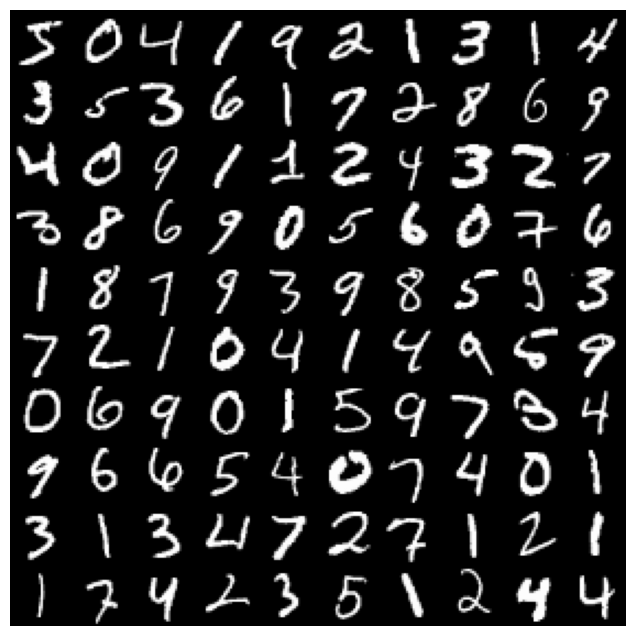

In [32]:
getRGB = True
setSizeTo32 = False
size = 32 if setSizeTo32 else 28
tgt_trX, tgt_trY, tgt_tsX, tgt_tsY = get_mnist(getRGB=getRGB, setSizeTo32=setSizeTo32)
#m,_,_,_ = tgt_trX.shape
#tr_idx = np.random.choice(m,min(m,TRAIN_SAMPLES_TO_USE))
#tgt_trX = tgt_trX[tr_idx,:,:,:]
#tgt_trY = tgt_trY[tr_idx]
#m,_,_,_ = tgt_tsX.shape
#ts_idx = np.random.choice(m,min(m,TEST_SAMPLES_TO_USE))
#tgt_tsX = tgt_tsX[ts_idx,:,:,:]
#tgt_tsY = tgt_tsY[ts_idx]
print('Tgt Train Min: Value- ',np.min(tgt_trX))
print('Tgt Train Max: Value- ',np.max(tgt_trX))
print('Tgt Test Min: Value- ',np.min(tgt_tsX))
print('Tgt Test Max: Value- ',np.max(tgt_tsX))
print('tgt_trX.shape: ', tgt_trX.shape)
print('tgt_trY.shape: ', tgt_trY.shape)
print('tgt_tsX.shape: ', tgt_tsX.shape)
print('tgt_tsY.shape: ', tgt_tsY.shape)


#Let's visualize few samples and their labels from the train and test dataset.
if getRGB:
    # For RGB svhn
    visx_tr = tgt_trX[:50,:,:,:].reshape(5,10,3,size,size).transpose(0,3,1,4,2).reshape(size*5,-1,3)
    visx_ts = tgt_tsX[:50,:,:,:].reshape(5,10,3,size,size).transpose(0,3,1,4,2).reshape(size*5,-1,3)
    visx = np.concatenate((visx_tr,visx_ts), axis=0)
    visx = (visx+1)/2. #scaling back to [0-1]
else:
    # For grayscale svhn
    visx_tr = tgt_trX[:50,:,:,:].squeeze().reshape(5,10,size,size).transpose(0,2,1,3).reshape(size*5,-1)
    visx_ts = tgt_tsX[:50,:,:,:].squeeze().reshape(5,10,size,size).transpose(0,2,1,3).reshape(size*5,-1)
    visx = np.concatenate((visx_tr,visx_ts), axis=0)

visy = np.concatenate((tgt_trY[:50],tgt_tsY[:50])).reshape(10,-1)
print('labels')
print(visy)
plt.figure(figsize = (8,8))
plt.axis('off')
if getRGB:
    plt.imshow(visx)
else:
    plt.imshow(visx,cmap='gray')

#convert to torch tensor
tgt_trX = torch.tensor(tgt_trX)
tgt_trY = torch.tensor(tgt_trY)
tgt_tsX = torch.tensor(tgt_tsX)
tgt_tsY = torch.tensor(tgt_tsY)

### Design the Network Modules (20 points)

Let's define the network architecures: 
Convolution Layers are represented as 'Conv(ch)', where 'ch' is the number of output channels. All convolutions are same conolutions with stride=3 and padding=1
Linear layers are represented as 'Linear(fts)', where 'fts' is the number of output features. 
Every Convolution and Linear Layer is followed by ReLU activation except if it is the last layer before the Loss function.
MaxPool layers are represented as 'MaxPool(fs)' where 'fs'=2 is the filter size with stride=2
BatchNorm layers are represented as 'BatchNorm(ch)', where 'ch' is the number of channels or inputs feature dimensions. For Convolution layers we use 'BacthNorm2d(ch)' and for linear layers we use 'BatchNorm1d(ch)'

FeatrureExtractor (Input = Batch_Size x 3 x 32 x 32 or Batch_Size x 3 x 28 x 28):<br>
    Conv(32) $\rightarrow$ Conv(32) $\rightarrow$ MaxPool(2) $\rightarrow$ BatchNorm(32) $\rightarrow$ Conv(64) $\rightarrow$ Conv(64) $\rightarrow$ MaxPool(2) $\rightarrow$ BatchNorm(64) $\rightarrow$ Conv(128) $\rightarrow$ Conv(128) $\rightarrow$ AdaptiveAvgPool2d(1) $\rightarrow$ Linear(128) $\rightarrow$ BatchNorm(128) <br><br>
LabelClassifier (Input = Batch_Size x 128): <br>
    Linear(64) $\rightarrow$ BatchNorm $\rightarrow$ Linear(64) $\rightarrow$ SoftmaxCrossEntropyLoss<br><br>
DomainClassifier (Input = Batch_Size x 128): <br>
     Linear(64) $\rightarrow$ BatchNorm $\rightarrow$ Linear(64) $\rightarrow$ BatchNorm $\rightarrow$ Linear(64) $\rightarrow$ SigmoidBinaryCrossEntropyLoss<br>

In [33]:
# Feel free to modify the architecture within certain constraints, to get better results. 
# Please check the comments for the testcases to understand the constraints on the network architecture. 

# The FeatrureExtractor network module is used to extract features from the source and the target data.
# Every image is extracted into a feature of 128 dimensions
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Define the components of the FeatrureExtractor
        # your code here
        # roey to calc the filter size
        # kernel_size = 3 stride = 3, padding = 1
        self.print_dim=False
        self.conv32 = nn.Conv2d(3,32,3,1,1)
        self.conv32_2 = nn.Conv2d(32,32,3,1,1)
        self.relu = nn.ReLU()
        # roey to update in and out
        self.linear = nn.Linear(1,128)
        self.conv64 = nn.Conv2d(32,64,3,1,1)
        self.conv64_2 = nn.Conv2d(64,64,3,1,1)
        self.conv128 = nn.Conv2d(64,128,3,1,1)
        self.conv128_2 = nn.Conv2d(128,128,3,1,1)
        self.maxPool2d = nn.MaxPool2d(2,2)
        self.batchNorm2d32 = nn.BatchNorm2d(32)
        self.batchNorm2d64 = nn.BatchNorm2d(64)
        self.batchNorm1d = nn.BatchNorm1d(128)
        self.adaptiveAvgPool2d = nn.AdaptiveAvgPool2d(1)

        # Set up the weight initialization mechanishm 
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        # Forward propagate through the FeatrureExtractor network module
        # your code here
        if self.print_dim == True:
          print(x.shape)
        # 5,3,32,32
        x = self.conv32(x)
        if self.print_dim == True:
          print(x.shape)
        # 5,32,32,32
        x = self.relu(x)        
        x = self.conv32_2(x)   
        # 5,32,32,32     
        if self.print_dim == True:
          print(x.shape)
        x = self.relu(x)
        x = self.maxPool2d(x)
        # 5,32,16,16    
        if self.print_dim == True:
          print(x.shape)    
        x = self.batchNorm2d32(x)
        # 5,32,16,16
        if self.print_dim == True:
          print("before conv64:",x.shape)
        x = self.conv64(x)
        if self.print_dim == True:
          print("after conv64:",x.shape)
        # 5,64,16,16
        x = self.relu(x)
        x = self.conv64_2(x)
        # 5,64,16,16
        if self.print_dim == True:
          print("after conv64_2:",x.shape)
        x = self.relu(x)
        x = self.maxPool2d(x)
        # 5,64,8,8
        if self.print_dim == True:
          print("after maxPool2d:",x.shape)
        x = self.batchNorm2d64(x)
        # 5,64,8,8
        if self.print_dim == True:
          print("after batchNorm2d64:",x.shape)
        x = self.conv128(x)
        # 5,128,8,8
        if self.print_dim == True:
          print("after conv128:",x.shape)
        x = self.relu(x)
        x = self.conv128_2(x)
        # 5,128,8,8
        if self.print_dim == True:
          print("after conv128_2:",x.shape)
        x = self.relu(x)
        x = self.adaptiveAvgPool2d(x)
        if self.print_dim == True:
          print("after adaptiveAvgPool2d:",x.shape)
        x = self.linear(x)
        if self.print_dim == True:
          print("after linear:",x.shape)
        x = x.squeeze(2)
        if self.print_dim == True:
          print("after squeeze1:",x.shape)
        x = x.sum(dim=2)
        x = x.squeeze()
        if self.print_dim == True:
          print("after squeeze2:",x.shape)
        x = self.batchNorm1d(x)
        if self.print_dim == True:
          print("after batchNorm1d:",x.shape)

        return x

# The LabelClassifier network module is used to classify the features (output of FeatureExtractor) into 10 categories
class LabelClassifier(nn.Module):
    def __init__(self):
        super(LabelClassifier, self).__init__()
        # Define the components of the LabelClassifier 
        # DO NOT define the loss layer. We will define it later
        # your code here
        self.linear1 = nn.Linear(128,64)
        self.batchNorm1d = nn.BatchNorm1d(64)
        self.linear2 = nn.Linear(64,10)
        self.relu = nn.ReLU()
        
        # Set up the weight initialization mechanishm 
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0.0, 0.02)

    def forward(self, x):
        # Forward propagate through the LabelClassifier network module
        # your code here
        x = self.linear1(x)
        x = self.relu(x)
        x = self.batchNorm1d(x)
        # last layer before the loss function
        x = self.linear2(x)
        
        return x

# The following class is meant to reverse the gradient during backpropagation 
# It has been defined - no changes needed
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lamda):
        ctx.lamda = lamda
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = (grad_output.neg() * ctx.lamda)
        return output, None

# The DomainClassifier module trains to distinguish between the source and target features 
# The input to the network are the features from the FeatureExtractor
class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        # Define the components of the DomainClassifier 
        # DO NOT define the loss layer. We will define it later
        # your code here
        self.linear1 = nn.Linear(128,64)
        self.batchNorm1d = nn.BatchNorm1d(64)
        self.linear2 = nn.Linear(64,64)
        self.relu = nn.ReLU()
        # last layer before the loss function
        self.linear3 = nn.Linear(64,1)

        # Set up the weight initialization mechanishm 
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0.0, 0.02)

    def forward(self, x, lam=0.0):
        # Forward propagate through the LabelClassifier network module
        # The Gradreverse has been implemented. 
        # Implement the other forward propoagation for the remianing componenets of the DomainClassifier
        x = GradReverse.apply(x, lam)
        # your code here
        x = self.linear1(x)
        x = self.relu(x)
        x = self.batchNorm1d(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.batchNorm1d(x)
        x = self.linear3(x)

        return torch.sigmoid(x)

In [34]:
# Testcases
# The input to the FeatureExtractor is a Tensor (m,3,s,s), where m is number of samples (arbitrary batch_size)
#        3 is the RGB channels, s is the image size. The FeatureExtractor has an AdaptiveAvgPool2d() layer 
#        feeding a fully connected layer. It is therefore not constarined to a specific image size. It works for both 28 and 32 
# The output of the FeatureExtractor is a Tensor (m,n), where m is number of samples (arbitrary batch_size) 
#        and n=128 is feature dimensions. 

# The input to the FeatureClassifier is a Tensor (m,n), where m is number of samples (arbitrary batch_size) 
#        and n=128 is feature dimensions
# The output of the FeatureClassifier is a Tensor (m,c), where m is number of samples (arbitrary batch_size) 
#        and c=10 is number of categories

# The input to the DomainClassifier is a Tensor (m,n), where m is number of samples (arbitrary batch_size) 
#        and n=128 is feature dimensions
# The output of the DomainClassifier is a Tensor (m,1), where m is number of samples (arbitrary batch_size) 
#        The values are between [0-1]

# The following testcases test only for the constraints above. 
# You are free to select your own architecture to get better results.

f_t = FeatureExtractor()
c_t = LabelClassifier()
d_t = DomainClassifier()
x_t = torch.Tensor(np.random.randn(5,3,32,32))
x_f_t = f_t(x_t)
npt.assert_array_equal(x_f_t.shape, (5,128))
x_f_t = torch.Tensor(np.random.randn(5,128))
x_c_t = c_t(x_f_t)
npt.assert_array_equal(x_c_t.shape, (5,10))
x_d_t = d_t(x_f_t)
npt.assert_array_equal(x_d_t.shape, (5,1))
assert torch.all(x_d_t>0) and torch.all(x_d_t<= 1.)

### Intialize Network Module Objects (10 points)

In [35]:
BATCH_SIZE = 64
LR = 1e-2 # learning rate
LR_decay_rate = 0.999 # learning schedule decay_rate
TOTAL_EPOCHS = 5 
LOG_PRINT_STEP = 200 # print training progress every LOG_PRINT_STEP iterations

# Intialize the following objects for the networks modules
# ftr_extr for FeatureExtractor
# lbl_clsfr for LabelClassifier
# dom_clsfr for DomainClassifier
# ftr_extr = 
# lbl_clsfr = 
# dom_clsfr = 
# your code here

ftr_extr = FeatureExtractor()
lbl_clsfr = LabelClassifier()
dom_clsfr = DomainClassifier()

# Move the network modules to the gpu (if gpu is present)
if is_cuda:
    ftr_extr = ftr_extr.cuda()
    lbl_clsfr = lbl_clsfr.cuda()
    dom_clsfr = dom_clsfr.cuda()

# Initialize the optimizer and the scheduler for learning rate
opt = optim.Adam(list(ftr_extr.parameters()) + list(lbl_clsfr.parameters()), betas=(0.9, 0.999), lr=LR, weight_decay=0.0005)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=LR_decay_rate)

# Define 'ce_criterion' the nn.CrossEntropyLoss object
# This module will implement the softmax and the crossentropy loss
# ce_criterion = 
# your code here
ce_criterion=nn.CrossEntropyLoss()

print("-----------------------------------------FeatrureExtractor---------------------------------------")
print(ftr_extr)
print("\n------------------------------------------LabelClassifier------------------------------------------")
print(lbl_clsfr)
print("\n------------------------------------------CrossEntropyLoss------------------------------------------")
print(ce_criterion)
print("\n------------------------------------------DomainClassifier------------------------------------------")
print(dom_clsfr)

-----------------------------------------FeatrureExtractor---------------------------------------
FeatureExtractor(
  (conv32): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (linear): Linear(in_features=1, out_features=128, bias=True)
  (conv64): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv64_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv128_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchNorm2d32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm2d64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm1d): BatchNorm1d(128, eps=

In [36]:
# Testcases
assert isinstance(ftr_extr, FeatureExtractor)
assert isinstance(lbl_clsfr, LabelClassifier)
assert isinstance(dom_clsfr, DomainClassifier)
assert isinstance(ce_criterion, nn.CrossEntropyLoss)

### Classifier Logits (5 points)

Define a function for forward pass through the FeatureExtractor and the LabelClassifier

In [37]:
def calc_clf_logits(x):
    '''
    The function propagates input x through the FeatureExtractor and the LabelClassifier
    Inputs: 
        x: Tensor of input images of dimensions (m,3,s,s), where m is number of samples, 
            3 is for the RGB channels, s is the image size
            
    Outputs:
        logits: Tensor of putputs logits of dimensions (m,10), where m is number of samples,
            10 is number of categories
    '''
    # your code here
    x = ftr_extr(x)
    logits = lbl_clsfr(x)
    
    return logits

In [38]:
# Testcases
# The following testcases test only for dimension constraints. 
x_t = torch.Tensor(np.random.randn(5,3,32,32))
if is_cuda:
    x_t = x_t.cuda()
npt.assert_array_equal(calc_clf_logits(x_t).shape, (5,10))

### Label Classifier Loss (5 points)

Define a function that gives gives the classification loss for the LabelClassifier module. 
The input is a Tensor of images along with corresponding labels. The images are input to the FeatureExtractor
followed by the LabelClassifier and the loss is calculated using CrossEntropy 
Use the 'calc_clf_logits()' function and the 'ce_criterion' nn.CrossEntropyLoss Object to calculate the loss

In [39]:
def src_clf_loss(img, Y):
    '''
    The function returns the CrossEntropyLoss error for classifying img where groundtruth is labels
    Inputs: 
        img: Tensor of input images of dimensions (m,3,s,s), where m is number of samples, 
                3 is for the RGB channels, s is the image size
        Y: groundtruth labels in Tensor of shape (m) with values in {0,1,,2, ..., 9}
            
    Outputs:
        clf_loss: scalar loss for the m images
    '''
    # your code here
    logist = calc_clf_logits(img)

    clf_loss = ce_criterion(logist,Y)
    
    return clf_loss

In [40]:
# Testcases
# The following testcases test only for dimension constraints. 
x_t = torch.Tensor(np.random.randn(5,3,32,32))
x_t.requires_grad = True
label_t = torch.empty(5, dtype=torch.long).random_(10)
if is_cuda:
    x_t = x_t.cuda()
    label_t = label_t.cuda()
out_t = src_clf_loss(x_t, label_t)
npt.assert_array_equal(out_t.shape, (1))

### Evaluate Model

Define a function 'evaluate_model(.)' that returns the accuracy of classification for given input images X and groundtruth labels Y.

In [41]:
def evaluate_model(X, Y):
    '''
    The function returns the accuracy of classification
    Inputs: 
        X: Tensor of input images of dimensions (m,3,s,s), where m is number of samples, 
                3 is for the RGB channels, s is the image size
        Y: groundtruth labels in Tensor of shape (m) with values in {0,1,,2, ..., 9}
            
    Outputs:
        acc: accuracy of classification
    '''   
    ftr_extr.eval()
    lbl_clsfr.eval()
    actual = []
    pred = []
    
    m = X.shape[0]
    for ii in range((m - 1) // BATCH_SIZE + 1):
        img = X[ii*BATCH_SIZE : (ii+1)*BATCH_SIZE, :]
        label = Y[ii*BATCH_SIZE : (ii+1)*BATCH_SIZE]
        if is_cuda:
            img = img.cuda()
            
        # use calc_clf_logits(.) with 'img' as inputs ti get the logits
        # Estimate the index of the max value in every row of the logits output, that is the 'predicted' label
        logits = calc_clf_logits(img)
        _, predicted = torch.max(logits.data, 1)
        actual += label.tolist()
        pred += predicted.tolist()
    acc = accuracy_score(y_true=actual, y_pred=pred) * 100
    return acc

### Train Classifier Model With Source Data (5 points)

We will train just FeatureExtractor and LabelClassifier with the source data and evaluate classification accuracies on the target data. The trained model is called 'Source-only'. We will train the FeatureExtractor and the LabelClassifier modules using the source data. 

In [42]:
print("Iterations per epoch: %d"%(src_trX.shape[0]//BATCH_SIZE))
lbl_clsfr.train()
ftr_extr.train()
m = src_trX.shape[0]
for epoch in range(TOTAL_EPOCHS):
    for ii in range((m - 1) // BATCH_SIZE + 1):
        s_img = src_trX[ii*BATCH_SIZE : (ii+1)*BATCH_SIZE, :]
        s_labels = src_trY[ii*BATCH_SIZE : (ii+1)*BATCH_SIZE]
        
        if is_cuda:
            s_img, s_labels = s_img.cuda(), s_labels.cuda()
        
        clf_loss = src_clf_loss(s_img, s_labels)
        loss = clf_loss
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        my_lr_scheduler.step()
                
        if ii % LOG_PRINT_STEP == 0:
            print("Epoch: %d/%d, iter: %4d, clf_err: %.4f, clf_LR: %.3E" \
                  %(epoch+1, TOTAL_EPOCHS, ii, clf_loss, opt.param_groups[0]['lr']))

Iterations per epoch: 1144
Epoch: 1/5, iter:    0, clf_err: 2.2971, clf_LR: 9.990E-03
Epoch: 1/5, iter:  200, clf_err: 1.6489, clf_LR: 8.178E-03
Epoch: 1/5, iter:  400, clf_err: 0.9967, clf_LR: 6.695E-03
Epoch: 1/5, iter:  600, clf_err: 0.5839, clf_LR: 5.481E-03
Epoch: 1/5, iter:  800, clf_err: 0.6151, clf_LR: 4.487E-03
Epoch: 1/5, iter: 1000, clf_err: 0.4332, clf_LR: 3.673E-03
Epoch: 2/5, iter:    0, clf_err: 0.8486, clf_LR: 3.177E-03
Epoch: 2/5, iter:  200, clf_err: 0.5718, clf_LR: 2.601E-03
Epoch: 2/5, iter:  400, clf_err: 0.3438, clf_LR: 2.129E-03
Epoch: 2/5, iter:  600, clf_err: 0.2903, clf_LR: 1.743E-03
Epoch: 2/5, iter:  800, clf_err: 0.2257, clf_LR: 1.427E-03
Epoch: 2/5, iter: 1000, clf_err: 0.2490, clf_LR: 1.168E-03
Epoch: 3/5, iter:    0, clf_err: 0.1978, clf_LR: 1.010E-03
Epoch: 3/5, iter:  200, clf_err: 0.3420, clf_LR: 8.272E-04
Epoch: 3/5, iter:  400, clf_err: 0.2407, clf_LR: 6.772E-04
Epoch: 3/5, iter:  600, clf_err: 0.2622, clf_LR: 5.544E-04
Epoch: 3/5, iter:  800, clf_e

### Evaluate Classification Accuracies With Source-only model (10 points)

Calculate accuracy on source and target datasets. Notice how the Network does not perform well on the target data. 

In [43]:
src_train_acc = evaluate_model(src_trX, src_trY)
src_test_acc = evaluate_model(src_tsX, src_tsY)
tgt_train_acc = evaluate_model(tgt_trX, tgt_trY)
tgt_test_acc = evaluate_model(tgt_tsX, tgt_tsY)
print("Source train acc: %.2f\nSource test acc: %.2f\nTarget train acc: %.2f\nTarget test acc: %.2f" \
      %(src_train_acc, src_test_acc, tgt_train_acc, tgt_test_acc))

#Testing for source test acc > 90%
assert src_train_acc > 90
assert src_test_acc > 90
assert src_train_acc > tgt_train_acc 
assert src_train_acc > tgt_test_acc 
assert src_test_acc > tgt_train_acc 
assert src_test_acc > tgt_test_acc 

Source train acc: 96.05
Source test acc: 94.51
Target train acc: 52.12
Target test acc: 53.97


### Intialize the Domain Alignment network  

Reintalize the network with same paramters for DANN training. This time we will use the DomainClassifier to align the domains in the DANN style

In [44]:
##############################################################################
################### DO NOT MODIFY THE CODE BELOW #############################    
##############################################################################
manual_seed = 0

random.seed(manual_seed)
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manual_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = '0'
    
############################################################################### 
LR = 1e-2
LR_decay_rate = 0.999
disc_LR = 1e-4
disc_LR_decay_rate = 0.999
TOTAL_EPOCHS = 5
LOG_PRINT_STEP = 200

# Intialize the following objects for the network modules
# ftr_extr for FeatureExtractor
# lbl_clsfr for LabelClassifier
# dom_clsfr for DomainClassifier
ftr_extr = FeatureExtractor()
lbl_clsfr = LabelClassifier()
dom_clsfr = DomainClassifier()

# Move the network modules to the gpu (if gpu is present)
if is_cuda:
    ftr_extr = ftr_extr.cuda()
    lbl_clsfr = lbl_clsfr.cuda()
    dom_clsfr = dom_clsfr.cuda()

# Initialize the optimizer for ftr_extr and lbl_clsfr 
opt = optim.Adam(list(ftr_extr.parameters()) + list(lbl_clsfr.parameters()), lr=LR, betas=[0.9, 0.999], weight_decay=0.0005)
# Setup the learning rate scheduler for the 'opt'
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=LR_decay_rate)

# Initialize the optimizer for dom_clsfr
optD = optim.Adam(dom_clsfr.parameters(), lr=disc_LR, betas=(0.9, 0.999), weight_decay=0.0005)
# We will not use a scheduler for the 'optD'
#my_lr_scheduler_D = torch.optim.lr_scheduler.ExponentialLR(optimizer=optD, gamma=disc_LR_decay_rate)

# define the crossentropyloss for LabelClassifier  and the 
ce_criterion = nn.CrossEntropyLoss()
# define the BinaryCrossentropyloss for the DomainClassifier
bce_criterion = nn.BCELoss()

### Importance of Domain Alignment (5 points)

The parameter $\lambda$ or 'lam' in our code, controls the importance of the DomainClassifier in the overall objective of domain alignment. The DomainClassifier gradient can conflict with the training of the LabelClassifier with noisy gradients in the initial stages of the training. We therefore set $\lambda=0$ initially and gradually increase it after the FeatureExtractor has stabilised. This scheduling of 'lam' is implemented in the following 'adjust_lambda' function. 
Refer to Sec 5.2.2 in the [DANN paper](https://arxiv.org/pdf/1505.07818.pdf) for more details. 

\begin{equation}
\lambda = \frac{2}{1 + \text{exp}(-\gamma.p)} -1
\end{equation}
where, $\gamma = 10$ and $p = \frac{itr + epoch\times no\_itrs\_per\_epoch}{n\_epochs \times no\_itrs\_per\_epoch}$ is the fraction of total iterations completed in the training.

In [53]:
def adjust_lambda(itr, epoch, no_itrs_per_epoch, n_epochs):
    '''
    returns the scheduled value of lam based on epoch and iteration number. 
    
    Inputs:
        itr: the iteration number in an epoch 
        epoch: the epoch number
        no_itrs_per_epoch: the number of iterations (number of mini-batches) in an epoch
        n_epochs: total number of epochs in the training
    '''
    # your code here
    p = (itr + epoch*no_itrs_per_epoch)/(n_epochs * no_itrs_per_epoch)
    gamma = 10
    lam = (2 / (1 + np.exp(-gamma * p))) - 1

    return lam

In [127]:
#Test
i = 1
epoch = 4
min_len = 100
nepochs = 10
lam = adjust_lambda(i, epoch, min_len, nepochs)
npt.assert_almost_equal(lam, 0.9643791367189494,decimal=5)

# I Run with the hidden TC and comment after
# HIDDEN TESTS ###
#i = 0
#epoch = 0
#min_len = 100
#nepochs = 10
#lam = adjust_lambda(i, epoch, min_len, nepochs)
#npt.assert_almost_equal(lam, 0.0, decimal=5)

#i = 0
#epoch = 5
#min_len = 100
#nepochs = 10
#lam = adjust_lambda(i, epoch, min_len, nepochs)
#npt.assert_almost_equal(lam, 0.9866142981514305, decimal=5)

#i = 5
#epoch = 2
#min_len = 100
#nepochs = 40
#lam = adjust_lambda(i, epoch, min_len, nepochs)
#npt.assert_almost_equal(lam, 0.25078469944110227, decimal=5)

#i = 100
#epoch = 10
#min_len = 100
#nepochs = 10
#lam = adjust_lambda(i, epoch, min_len, nepochs)
#npt.assert_almost_equal(lam, 0.9999665971563041, decimal=5)
# HIDDEN TESTS ###

### Domain Classification Loss (10 points)

Similar to the Label Classifier Loss function defined in 'src_clf_loss(.)', we will define a Domain Classifier Loss function 'domain_clf_err(.)' which will return the loss of domain classification. 
The input is a Tensor of source images 's_img', a Tensor of target images 't_img' and the $\lambda$ parameter 'lam'. We need to create the labels for the groundtruth. The source images belong to class 1 and target images to class 0. 
Propagate 's_img' through the FeatureExtractor and 't_img' through the FeatureExtractor. Concatenate the outputs and propagate the concatenated result through the DomainClasssifier to obtain the logits. 
Apply the 'bce_criterion()' defined earlier to determine the loss based on the logits and the groundtruth. 
The 'bce_criterion' is similar to 'ce_criterion' for CrossEntropyLoss

It may not be possible to concatenate 's_img' and 't_img' and forward propagate the concatenated output through the FeatureExtractor and DomainClassifier - there may be a dimension mismatch. 

In [123]:
def domain_clf_loss(s_img, t_img, lam):
    '''
    The function returns the BinaryCrosEntropyLoss trying to distingiish between the source images 's_img'
    from the target images 't_img'
    Inputs: 
        s_img: Tensor of source input images of dimensions (m,3,32,32), where m is number of samples, 
                3 is for the RGB channels, 32 is the image size
        t_img: Tensor of target input images of dimensions (m,3,28,28), where m is number of samples, 
                3 is for the RGB channels, 28 is the image size
        lam: lambda parameter controlling the importance of domain alignment
            
    Outputs:
        dom_loss: scalar loss of domain classification
    '''
    # Generate the groundtruth labels 1 for source and 0 for target
    # Concatenate the groundtruth labels to get 'labels' and move 'labels' to cuda() if is_cuda
    # Concatenate the output of 'ftr_extr(s_img) using 's_img' and 'ftr_extr(t_img) using 't_img' to get 'imgs'
    # and move 'imgs' to cuda if is_cuda
    # Forward propagate 'imgs' through 'dom_clsfr(.)' using 'lam' to get the logits for domain classification
    # Estimate domain classification loss 'dom_loss' by comparing the logits with the groundtruth using bce_criterion(.)
    # your code here
    
    # Generate and concatenate lables
    m_s,d_s,w_s,h_s = s_img.size()
    m_t,d_t,w_t,h_t = t_img.size()
    s_lables = np.ones((m_s,1))
    t_lables = np.ones((m_t,1))
    lables = np.concatenate((s_lables,t_lables),axis=0)
    lables_t = torch.from_numpy(lables)
    lables_t = lables_t.float()
    s_img = ftr_extr(s_img)
    t_img = ftr_extr(t_img)
    s_img_cpu = s_img.cpu()
    t_img_cpu = t_img.cpu()

    images = torch.cat((s_img_cpu,t_img_cpu),axis=0)

    if is_cuda:
      images = images.cuda()
      lables_t = lables_t.cuda()  

    logits = dom_clsfr(images,lam)
    dom_loss = bce_criterion(logits,lables_t)

    return dom_loss

In [124]:
# Testcases
# The following testcases test only for dimension constraints. 
xs_t = torch.Tensor(np.random.randn(5,3,32,32))
xt_t = torch.Tensor(np.random.randn(5,3,32,32))
if is_cuda:
    xs_t = xs_t.cuda()
    xt_t = xt_t.cuda()
out_t = domain_clf_loss(xs_t, xt_t, lam=1.)
npt.assert_array_equal(out_t.shape, (1))

### Train the DANN Network (10 points)

DANN training loop. 

In [125]:
max_len = max(src_trX.shape[0], tgt_trX.shape[0])
print("Iterations per epoch: %d"%(max_len//BATCH_SIZE))
lbl_clsfr.train()
ftr_extr.train()
dom_clsfr.train()

src_bigger = False
#repeat indices since datasets are of different sizes
src_idx = range((src_trX.shape[0] - 1) // BATCH_SIZE + 1)
tgt_idx = range((tgt_trX.shape[0] - 1) // BATCH_SIZE + 1)
if src_trX.shape[0] > tgt_trX.shape[0]:
    tgt_idx = np.resize(tgt_idx, src_trX.shape[0])
    src_bigger = True
else:
    src_idx = np.resize(src_idx, tgt_trX.shape[0])
    
for epoch in range(TOTAL_EPOCHS):
    for ii, jj in zip(src_idx, tgt_idx):
        s_img = src_trX[ii*BATCH_SIZE : (ii+1)*BATCH_SIZE, :]
        s_labels = src_trY[ii*BATCH_SIZE : (ii+1)*BATCH_SIZE]
        t_img = tgt_trX[jj*BATCH_SIZE : (jj+1)*BATCH_SIZE, :]
        t_labels = tgt_trY[jj*BATCH_SIZE : (jj+1)*BATCH_SIZE]
        
        if src_bigger:
            lam = adjust_lambda(ii, epoch, max_len//BATCH_SIZE, TOTAL_EPOCHS)
        else:
            lam = adjust_lambda(jj, epoch, max_len//BATCH_SIZE, TOTAL_EPOCHS)
            
        if is_cuda:
            s_img, s_labels, t_img, t_labels = s_img.cuda(), s_labels.cuda(), t_img.cuda(), t_labels.cuda()
        
        clf_loss = src_clf_loss(s_img, s_labels)
        
        dom_loss = domain_clf_loss(s_img, t_img, lam)
                  
        loss = clf_loss + dom_loss
        
        opt.zero_grad()
        optD.zero_grad()
        loss.backward()
        opt.step()
        optD.step()
        my_lr_scheduler.step()
        #my_lr_scheduler_D.step()
        
        if src_bigger:
            if ii % LOG_PRINT_STEP == 0:
                print("Epoch: %d/%d, iter: %4d, lambda: %.2f, clf_loss: %.4f, clf_LR: %.3E, dom_loss: %.4f, dom_LR: %.3E"\
                      %(epoch+1, TOTAL_EPOCHS, ii, lam, clf_loss, opt.param_groups[0]['lr'], dom_loss, optD.param_groups[0]['lr']))
        else:
            if jj % LOG_PRINT_STEP == 0:
                print("Epoch: %d/%d, iter: %4d, lambda: %.2f, clf_err: %.4f, clf_LR: %.3E, disc_err: %.4f, dom_LR: %.3E"\
                      %(epoch+1, TOTAL_EPOCHS, jj, lam, clf_loss, opt.param_groups[0]['lr'], dom_loss, optD.param_groups[0]['lr']))

Iterations per epoch: 1144
Epoch: 1/5, iter:    0, lambda: 0.00, clf_loss: 2.3335, clf_LR: 9.990E-03, dom_loss: 0.6408, dom_LR: 1.000E-04
Epoch: 1/5, iter:  200, lambda: 0.17, clf_loss: 2.0049, clf_LR: 8.178E-03, dom_loss: 0.6097, dom_LR: 1.000E-04
Epoch: 1/5, iter:  400, lambda: 0.34, clf_loss: 0.9589, clf_LR: 6.695E-03, dom_loss: 0.5295, dom_LR: 1.000E-04
Epoch: 1/5, iter:  600, lambda: 0.48, clf_loss: 0.5628, clf_LR: 5.481E-03, dom_loss: 0.4181, dom_LR: 1.000E-04
Epoch: 1/5, iter:  800, lambda: 0.60, clf_loss: 0.3462, clf_LR: 4.487E-03, dom_loss: 0.3089, dom_LR: 1.000E-04
Epoch: 1/5, iter: 1000, lambda: 0.70, clf_loss: 0.3742, clf_LR: 3.673E-03, dom_loss: 0.2205, dom_LR: 1.000E-04
Epoch: 2/5, iter:    0, lambda: 0.76, clf_loss: 0.2728, clf_LR: 3.177E-03, dom_loss: 0.1718, dom_LR: 1.000E-04
Epoch: 2/5, iter:  200, lambda: 0.83, clf_loss: 0.4891, clf_LR: 2.601E-03, dom_loss: 0.1226, dom_LR: 1.000E-04
Epoch: 2/5, iter:  400, lambda: 0.87, clf_loss: 0.2623, clf_LR: 2.129E-03, dom_loss: 

### Evaluate the DANN Network (20 points)

Calculate accuracy on source and target datasets using DANN. Observe the improvement in the target classification accuracies with the alignment of the source and target datasets. You should observe the accuracy of the target increase by at least 10 points compared to Source-only training. The settings mentioned here yielded a target test accuracy of 71%. 
Modify the network and the training procedure to the extent allowed to improve the target classification accuracies.

In [128]:
src_train_acc2 = evaluate_model(src_trX, src_trY)
src_test_acc2 = evaluate_model(src_tsX, src_tsY)
tgt_train_acc2 = evaluate_model(tgt_trX, tgt_trY)
tgt_test_acc2 = evaluate_model(tgt_tsX, tgt_tsY)
print("With Domain Adversarial Training:\nSource train acc: %.2f\nSource test acc: %.2f\nTarget train acc: %.2f\nTarget test acc: %.2f" \
      %(src_train_acc2, src_test_acc2, tgt_train_acc2, tgt_test_acc2))

# Hidden testcases follow 
# Test improvement of target accuracy by at least 10 points

# I Run with the hidden TC and comment after
# HIDDEN TESTS ###
#assert src_train_acc > 85
#assert src_test_acc > 85
#assert tgt_train_acc2 > 60
#assert tgt_test_acc2 > 60
#assert tgt_train_acc2 > tgt_train_acc + 10
#assert tgt_test_acc2 > tgt_test_acc + 10
# HIDDEN TESTS ###


With Domain Adversarial Training:
Source train acc: 93.01
Source test acc: 92.27
Target train acc: 68.21
Target test acc: 70.28


#### The assignment is graded both manually and using autograding